In [2]:
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import librosa
from IPython.display import Audio
from librosa.feature.inverse import mel_to_audio

from src.train import train
from src.NSynthDataset import NSynthDataset
from src.utils import estimate_pitch
from src.WaveGAN import WaveGANGenerator
from src.SpecGAN import SpecGANGenerator

In [39]:
batch_size = 50
z_size = 1000

# min len =16000
sr = 8191
duration = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [40]:
os.chdir('../../..')
path = 'mnt/data/public/NSynth/'

In [41]:
train_set = NSynthDataset(data_path=path, mel=True, sampling_rate=sr, duration=duration, min_class_count=10000, max_class_count=2000, pitched_z=True, z_size=z_size)#, limit=1000)

In [42]:
gen = SpecGANGenerator(z_size, train_set.label_size, train_set.y_size).to(device)

gen.load_state_dict(torch.load(f'users/adcy353/GANs-Conditional-Audio-Synthesis/models/spec2/G_1e-05-25-180.pt'))
gen.eval()

SpecGANGenerator(
  (avgpool): AdaptiveMaxPool2d(output_size=(128, 128))
  (fc): Linear(in_features=1005, out_features=16384, bias=True)
  (deconv): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (9): Tanh()
  )
)

In [50]:
def display_spec(specs):
    fig, axs = plt.subplots(1, len(specs), figsize=(15, 5))
    for i in range(len(specs)):
        librosa.display.specshow(librosa.power_to_db(specs[i], ref=np.max),  y_axis='mel', x_axis='time', ax=axs[i])
        #axs[i].set_cbar(format='%+2.0f dB')
        axs[i].set_title('Mel Spectrogram')
        #axs[i].tight_layout()
    plt.show()    



organ_electronic 50


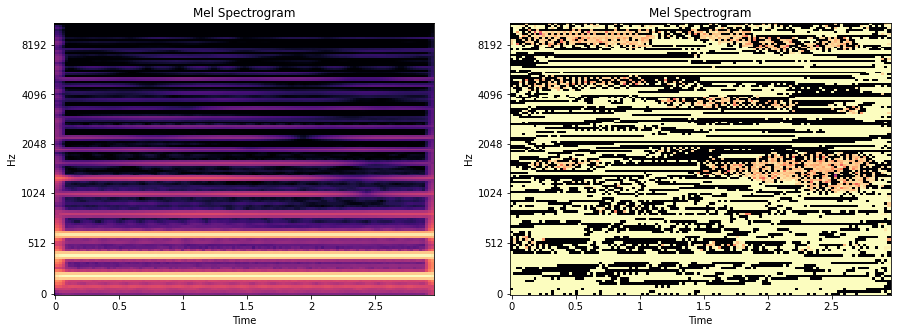

[nan]

string_acoustic 56


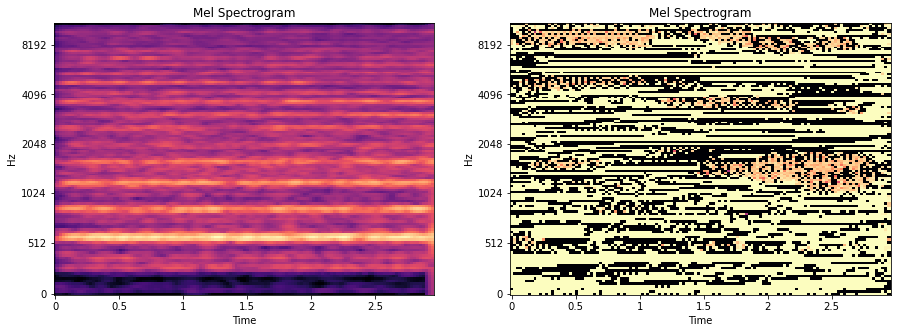

[nan]

bass_synthetic 60


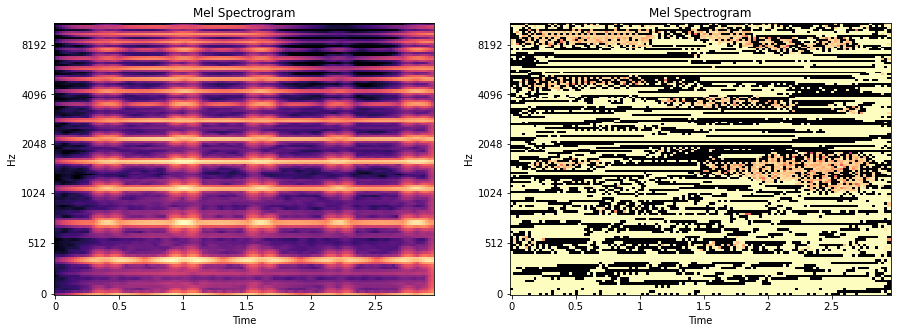

[nan]

string_acoustic 68


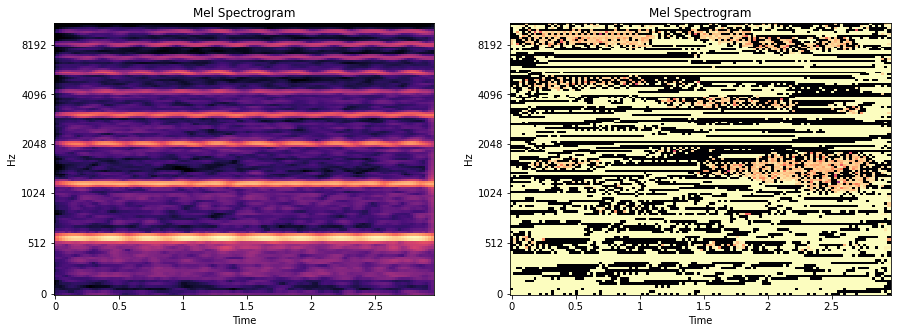

[nan]

keyboard_electronic 59


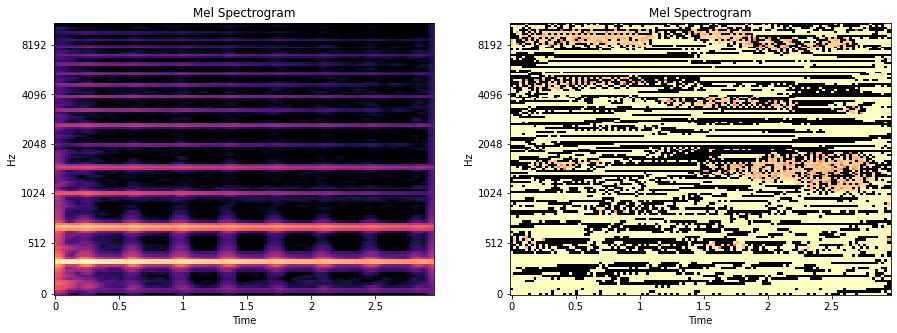

[nan]

organ_electronic 74


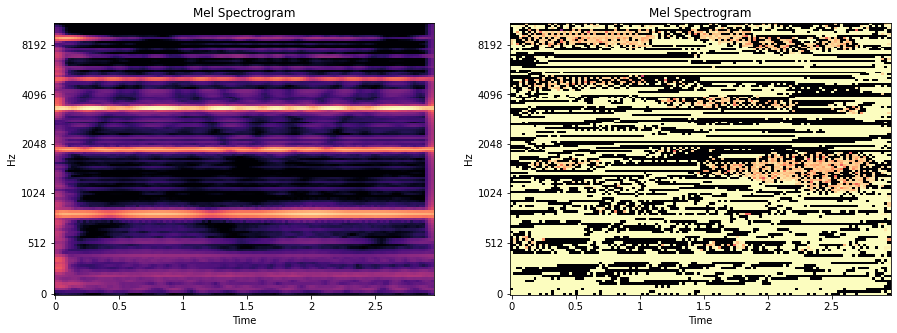

[nan]

keyboard_electronic 59


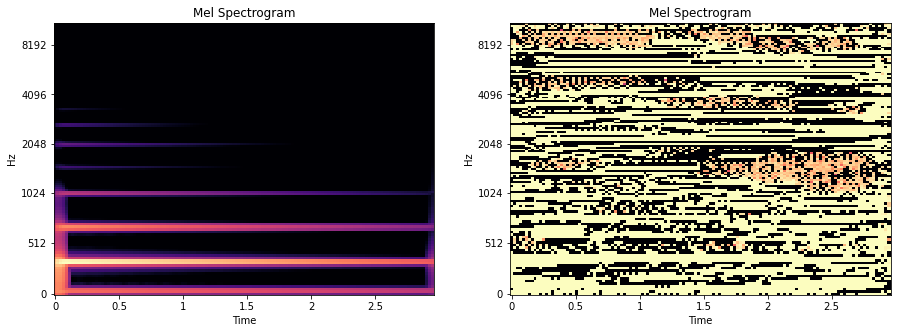

[nan]

organ_electronic 61


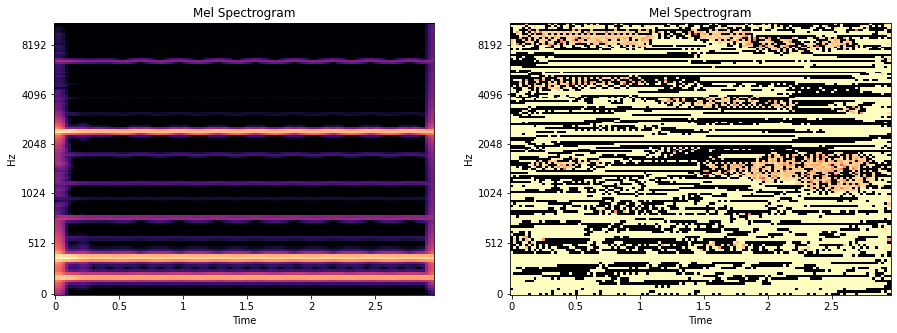

[nan]

organ_electronic 55


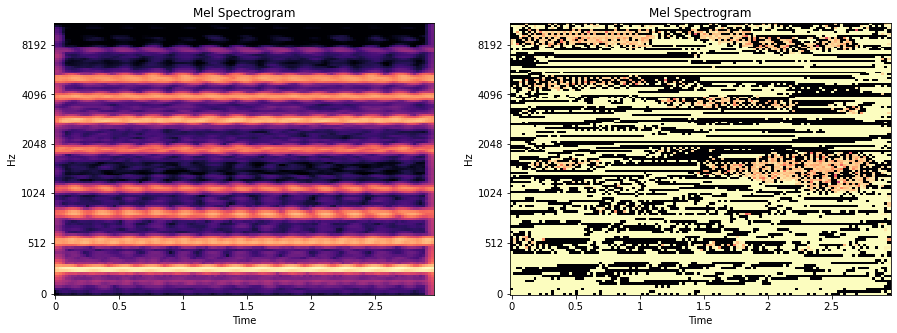

[nan]

bass_synthetic 73


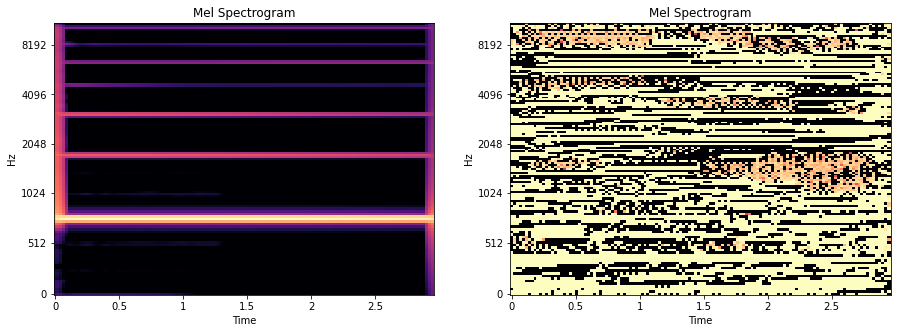

[nan]


In [51]:
s_i = []
for i in range(0, 900, 95):
    w, l, z = train_set.__getitem__(i)
    inst = train_set.annot.loc[train_set.fnames[i], 'instrument_class_str']
    pitch = train_set.annot.loc[train_set.fnames[i], 'pitch']
    
    print(f'\n{inst} {pitch}')
    
    s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
    s.to(torch.device('cpu'))
    s = s.detach().cpu()
    display_spec((w, s))
        
    w_audio = mel_to_audio(np.array(w), sr=train_set.sampling_rate, n_fft=1024, hop_length=128)
    s_audio = mel_to_audio(np.array(s), sr=train_set.sampling_rate, n_fft=1024, hop_length=128)
    display(Audio(w_audio, rate=sr))
    display(Audio(s_audio, rate=sr))
    
    print(f'{estimate_pitch(s, sr)}')
    s_i.append(s)

In [22]:
Audio(w, rate=sr)

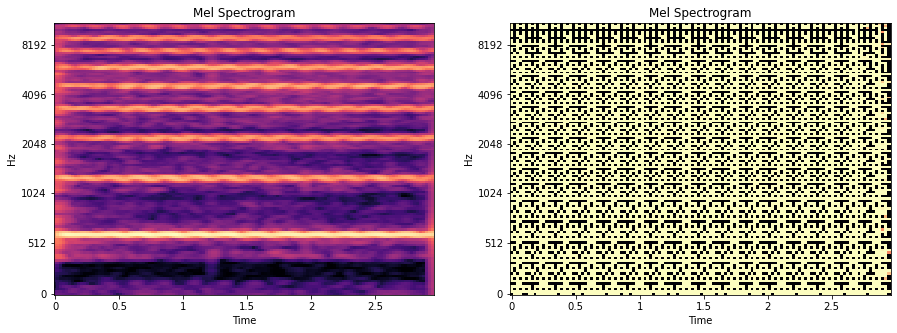

In [23]:
#z = torch.rand(1, 100).to(torch.device('cuda'))
i = 42
w, l, z = train_set.__getitem__(i)
s = gen.forward(z.unsqueeze(0).to(device), l.unsqueeze(0).to(device))
s.to(torch.device('cpu'))
s = s.detach().cpu()
#plt.imshow(s)
display_spec((w, s))
display(Audio(w_audio, rate=sr))
display(Audio(s_audio, rate=sr))
#plt.imshow(w)
#Audio(s, rate=sr)

In [98]:
estimate_pitch(s, sr)

array([nan])

In [40]:
import numpy as np
print(s.shape, w.shape)
Audio(z, rate=sr)

torch.Size([16000]) torch.Size([16000])


In [55]:
z_rd = 2 * torch.rand(z_size) - 1
z_noise = z.clone() + z_rd

Text(0.5, 1.0, 'Resulting generator input')

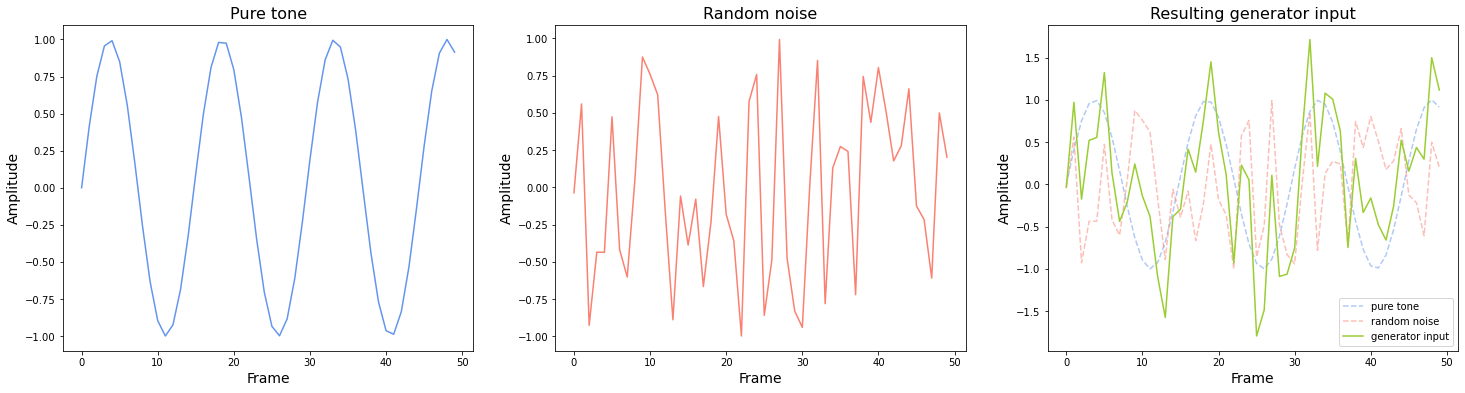

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
ax[0].plot(z[:50], c='cornflowerblue')
ax[1].plot(z_rd[:50], c='salmon')
#ax[2].plot(z_noise[:50], c='yellowgreen')

ax[2].plot(z[:50], 'g--', c='cornflowerblue', alpha=0.5, label='pure tone')
ax[2].plot(z_rd[:50], 'g--', c='salmon', alpha=0.5, label='random noise')
ax[2].plot(z_noise[:50], c='yellowgreen', label='generator input')
ax[2].legend()
           
for a in ax:
    a.set_xlabel('Frame', fontdict={'fontsize': 14})
    a.set_ylabel('Amplitude', fontdict={'fontsize': 14})

ax[0].set_title('Pure tone', fontdict={'fontsize': 16})
ax[1].set_title('Random noise', fontdict={'fontsize': 16})
ax[2].set_title('Resulting generator input', fontdict={'fontsize': 16})
#ax[3].set_title('Generator input')

#fig.title('pitched_input.png')
#fig.savefig('/Users/elisa/Desktop/Thesis/img/pitched_input.png')

Audio(z_noise, rate=sr)

s_i[0] / max(np.abs(s_i[0])) /100